# Decision Trees (Part 2)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix

In [2]:
plt.rcParams.update({'font.size':16,'figure.figsize':(12,8)})

## Loading data from NeuroElectro

In [3]:
df = pd.read_csv('data/article_ephys_metadata_curated.csv',delimiter='\t').set_index('Index')
df.head(3)

,Title,Pmid,PubYear,LastAuthor,ArticleID,TableID,NeuronName,NeuronLongName,NeuronPrefName,NeuroNERAnnots,...,sahpvolt_err,sahpvolt_n,sahpvolt_sd,sahpvolt_note,mahpvolt,mahpvolt_raw,mahpvolt_err,mahpvolt_n,mahpvolt_sd,mahpvolt_note
Index,,,,,,,,,,,,,,,,,,,,,
150,Cell type-specific effects of adenosine on cor...,24108800,2015,Feldmeyer D,88449,35984.0,Neocortex basket cell,medial prefrontal cortex fast spiking interne...,medial prefrontal cortex fast spiking interne...,"[ABA_REGION:714, HBP_EPHYS:0000080, HBP_EPHYS_...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
149,Cell type-specific effects of adenosine on cor...,24108800,2015,Feldmeyer D,88449,35984.0,Neocortex Martinotti cell,medial prefrontal cortex low-threshold spiking...,medial prefrontal cortex low-threshold spiking...,"[ABA_REGION:714, HBP_EPHYS:0000110, HBP_EPHYS_...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
151,Cell type-specific effects of adenosine on cor...,24108800,2015,Feldmeyer D,88449,35984.0,Neocortex basket cell,somatosensory cortex fast-firing interneuron,somatosensory cortex fast-firing interneuron,"[ABA_REGION:453, HBP_EPHYS:0000080, HBP_EPHYS_...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## There are so many variables to choose from!  

In [4]:
print(list(df))

['Title', 'Pmid', 'PubYear', 'LastAuthor', 'ArticleID', 'TableID', 'NeuronName', 'NeuronLongName', 'NeuronPrefName', 'NeuroNERAnnots', 'BrainRegion', 'MetadataCurated', 'Species', 'Strain', 'ElectrodeType', 'PrepType', 'JxnPotential', 'JxnOffset', 'RecTemp', 'AnimalAge', 'AnimalWeight', 'FlagSoln', 'ExternalSolution', 'ExternalSolution_conf', 'external_0_Mg', 'external_0_Ca', 'external_0_Na', 'external_0_Cl', 'external_0_K', 'external_0_pH', 'InternalSolution', 'InternalSolution_conf', 'internal_0_Mg', 'internal_0_Ca', 'internal_0_Na', 'internal_0_Cl', 'internal_0_K', 'internal_0_pH', 'MetadataNote', 'TableNote', 'rin', 'rin_raw', 'rin_err', 'rin_n', 'rin_sd', 'rin_note', 'rmp', 'rmp_raw', 'rmp_err', 'rmp_n', 'rmp_sd', 'rmp_note', 'apthr', 'apthr_raw', 'apthr_err', 'apthr_n', 'apthr_sd', 'apthr_note', 'apamp', 'apamp_raw', 'apamp_err', 'apamp_n', 'apamp_sd', 'apamp_note', 'aphw', 'aphw_raw', 'aphw_err', 'aphw_n', 'aphw_sd', 'aphw_note', 'tau', 'tau_raw', 'tau_err', 'tau_n', 'tau_sd', '

## First we choose something to classify

In [5]:
target = 'NeuronName'
df_target = df[target]
df_target.head(7)

Index
150                  Neocortex basket cell
149              Neocortex Martinotti cell
151                  Neocortex basket cell
152             Neocortex interneuron deep
88      Neocortex pyramidal cell layer 2-3
89      Neocortex pyramidal cell layer 2-3
1449    Neocortex pyramidal cell layer 2-3
Name: NeuronName, dtype: object

## Then we choose some variables/features to use to predict these classes (neuron types)

In [6]:
numerical_predictors = ['PubYear', 'RecTemp', 'rin', 'rmp', 'apthr', 'apamp', 'aphw', 'tau']
categorical_predictors = ['BrainRegion', 'Species', 'Strain', 'ElectrodeType', 'PrepType']

df_predictors = df[numerical_predictors+categorical_predictors]
df_predictors.head()

,PubYear,RecTemp,rin,rmp,apthr,apamp,aphw,tau,BrainRegion,Species,Strain,ElectrodeType,PrepType
Index,,,,,,,,,,,,,
150,2015,30.0,178.0,-72.2,NaN,NaN,0.38,7.9,Isocortex,Rats,"Rats, Wistar",Patch-clamp,in vitro
149,2015,30.0,361.0,-66.3,NaN,NaN,0.79,27.4,Isocortex,Rats,"Rats, Wistar",Patch-clamp,in vitro
151,2015,30.0,135.0,-68.0,NaN,NaN,0.20,8.0,Isocortex,Rats,"Rats, Wistar",Patch-clamp,in vitro
152,2015,30.0,83.0,-65.0,NaN,NaN,0.37,7.4,NaN,Rats,"Rats, Wistar",Patch-clamp,in vitro
88,2015,22.0,291.0,-64.3,-41.1,73.2,1.57,25.7,Isocortex,Macaca mulatta,Other,Patch-clamp,in vitro


## How do we handle categorical data?  

### "One Hot Encoding" (that is really the name)

In [7]:
df_predictors = pd.get_dummies(df_predictors) # Turns categorical data into yes/no data
df_predictors.head()

,PubYear,RecTemp,rin,rmp,apthr,apamp,aphw,tau,BrainRegion_Cerebellum,BrainRegion_Cortical subplate,...,"ElectrodeType_Patch-clamp, Sharp",ElectrodeType_Perforated patch,"ElectrodeType_Perforated patch, Patch-clamp",ElectrodeType_Sharp,PrepType_Other,"PrepType_Other, in vitro",PrepType_cell culture,PrepType_in vitro,"PrepType_in vitro, cell culture",PrepType_in vivo
Index,,,,,,,,,,,,,,,,,,,,,
150,2015,30.0,178.0,-72.2,NaN,NaN,0.38,7.9,0,0,...,0,0,0,0,0,0,0,1,0,0
149,2015,30.0,361.0,-66.3,NaN,NaN,0.79,27.4,0,0,...,0,0,0,0,0,0,0,1,0,0
151,2015,30.0,135.0,-68.0,NaN,NaN,0.20,8.0,0,0,...,0,0,0,0,0,0,0,1,0,0
152,2015,30.0,83.0,-65.0,NaN,NaN,0.37,7.4,0,0,...,0,0,0,0,0,0,0,1,0,0
88,2015,22.0,291.0,-64.3,-41.1,73.2,1.57,25.7,0,0,...,0,0,0,0,0,0,0,1,0,0


## As usual, most algorithms don't work with missing data.

### But every row might contain some missing data, and we don't want to drop all the rows!

## Solution: Imputation

In [8]:
df_predictors.head(3)

,PubYear,RecTemp,rin,rmp,apthr,apamp,aphw,tau,BrainRegion_Cerebellum,BrainRegion_Cortical subplate,...,"ElectrodeType_Patch-clamp, Sharp",ElectrodeType_Perforated patch,"ElectrodeType_Perforated patch, Patch-clamp",ElectrodeType_Sharp,PrepType_Other,"PrepType_Other, in vitro",PrepType_cell culture,PrepType_in vitro,"PrepType_in vitro, cell culture",PrepType_in vivo
Index,,,,,,,,,,,,,,,,,,,,,
150,2015,30.0,178.0,-72.2,NaN,NaN,0.38,7.9,0,0,...,0,0,0,0,0,0,0,1,0,0
149,2015,30.0,361.0,-66.3,NaN,NaN,0.79,27.4,0,0,...,0,0,0,0,0,0,0,1,0,0
151,2015,30.0,135.0,-68.0,NaN,NaN,0.20,8.0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [9]:
df_predictors = df_predictors.fillna(df_predictors.mean()) # Fills missing values with the mean from that column
df_predictors.head(3)

,PubYear,RecTemp,rin,rmp,apthr,apamp,aphw,tau,BrainRegion_Cerebellum,BrainRegion_Cortical subplate,...,"ElectrodeType_Patch-clamp, Sharp",ElectrodeType_Perforated patch,"ElectrodeType_Perforated patch, Patch-clamp",ElectrodeType_Sharp,PrepType_Other,"PrepType_Other, in vitro",PrepType_cell culture,PrepType_in vitro,"PrepType_in vitro, cell culture",PrepType_in vivo
Index,,,,,,,,,,,,,,,,,,,,,
150,2015,30.0,178.0,-72.2,-41.830232,71.934393,0.38,7.9,0,0,...,0,0,0,0,0,0,0,1,0,0
149,2015,30.0,361.0,-66.3,-41.830232,71.934393,0.79,27.4,0,0,...,0,0,0,0,0,0,0,1,0,0
151,2015,30.0,135.0,-68.0,-41.830232,71.934393,0.20,8.0,0,0,...,0,0,0,0,0,0,0,1,0,0


## Classification is too hard if we have hundreds of classes, some of which only have a few members

### Let's restrict classification to the ten most common classes

In [10]:
df_target.value_counts()[:10]

Other                                 291
Neocortex pyramidal cell layer 5-6    123
Hippocampus CA1 pyramidal cell        116
Neocortex basket cell                  74
Neocortex pyramidal cell layer 2-3     71
Neocortex uncharacterized cell         49
Neostriatum medium spiny neuron        40
Neocortex Martinotti cell              37
Subiculum pyramidal cell               31
Neostriatum gabaergic interneuron      29
Name: NeuronName, dtype: int64

In [11]:
top_10_cell_types = list(df_target.value_counts(normalize=True).index)[:10]
top_10_cell_type_indices = df_target.isin(top_10_cell_types)
df_target = df_target[top_10_cell_type_indices]
df_predictors = df_predictors[top_10_cell_type_indices]

## Now let's try running a classification algorithm

In [12]:
# Initialize the classification algorithm (Random Forest Classification)
rfc = RandomForestClassifier(n_estimators=100,oob_score=True)
# Run the classification algorithm
rfc.fit(df_predictors,df_target)
# Assess the in-sample performance
print("The predicted cross-validation classification performance is %.3g%%" % (rfc.oob_score_*100))

The predicted cross-validation classification performance is 83.9%


## That sounds pretty good, but we can try actual cross-validation instead of just guessing.  

In [13]:
scores = cross_val_score(rfc, df_predictors, df_target)
for i,score in enumerate(scores):
    print("On cross-validation split #%d, the classification performance was %.3g%%" % (i+1,score*100))

On cross-validation split #1, the classification performance was 75.3%
On cross-validation split #2, the classification performance was 76.7%
On cross-validation split #3, the classification performance was 71.7%


## Which classes are we classifying well, and where are we making mistakes?  

### e.g. when are we mistaking one cell type for another?  

## The 'confusion matrix'

In [14]:
def plot_confusion_matrix(predictions,actual):
    # Split the data into a training set and a test set
    predictions = cross_val_predict(rfc, df_predictors, df_target) # Make out-of-sample predictions
    classes = list(set(df_target)) # A list of all the possible classes (the neuron names)
    cm = confusion_matrix(df_target, predictions, labels=classes) # Generate the confusion matrix
    cm = 100*cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # Normalize and convert to percentage
    plt.pcolor(cm,cmap='Reds') # Plot using the red colormap
    plt.colorbar().set_label('Percent classified as this') # Add the color scale
    ticks = np.arange(0.5,10.5) # The numeric valies of the axis tick positions
    plt.xticks(ticks,classes,rotation=90) # Add the x-axis ticks
    plt.yticks(ticks,classes); # Add the y-axis ticks

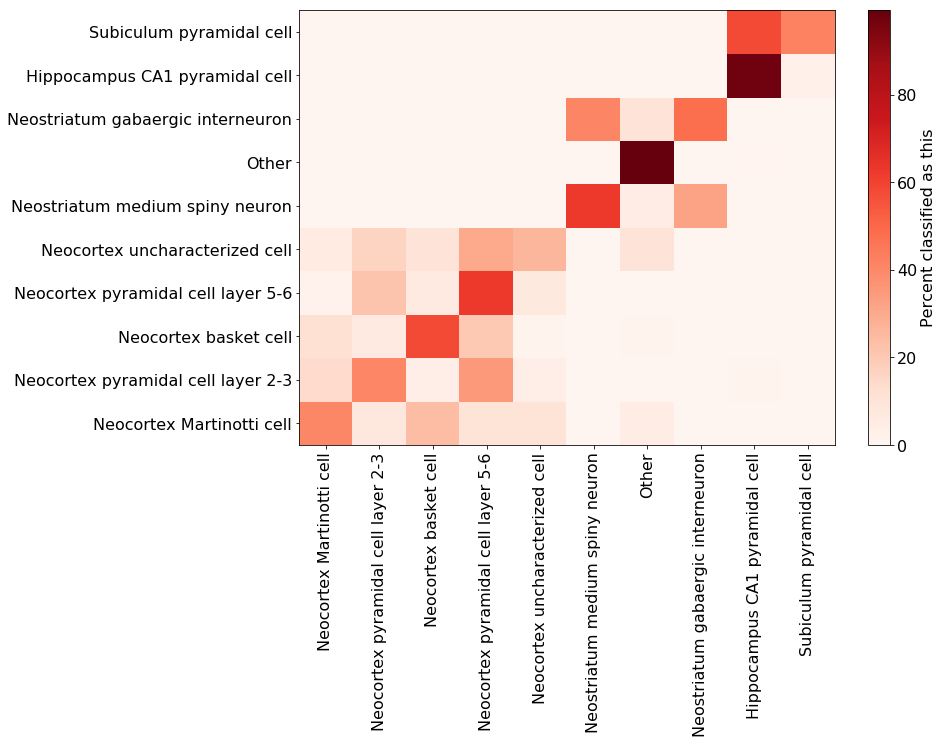

In [15]:
predictions = cross_val_predict(rfc, df_predictors, df_target) # Make out-of-sample predictions
plot_confusion_matrix(predictions,df_target)

## What features are important for classification?

### Which ones have the equivalent of large coefficients in a regression model?

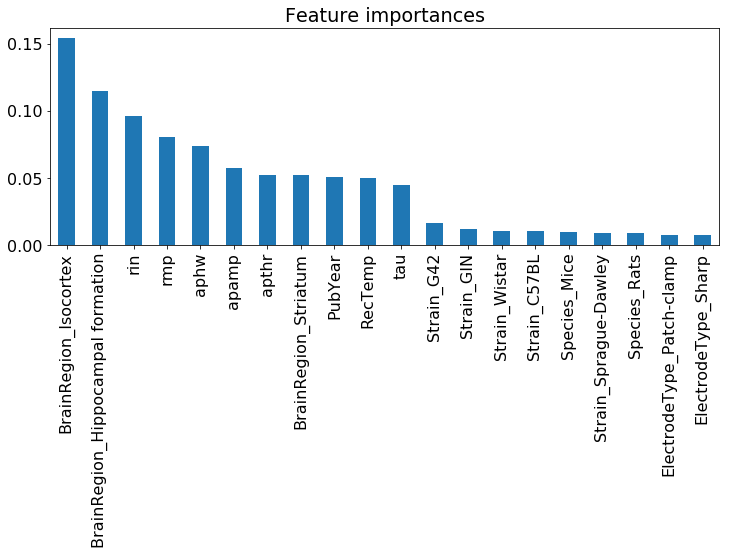

In [16]:
df_importances = pd.Series(rfc.feature_importances_,index=df_predictors.columns).sort_values(ascending=False)
df_importances.iloc[:20].plot.bar(title='Feature importances',figsize=(12,4));